# Моделирање на сценарија со вакцинација

In [52]:
from epydemic import NetworkGenerator
import numpy as np
import networkx as nx
import epydemic
from mpmath import *
import math
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.35)

In [4]:
class PowerLawWithCutoffNetwork(epydemic.NetworkGenerator):
    N = 'hcn.N'           #: Experimental parameter for the order of the network
    ALPHA = 'hcn.alpha'   #: Experimental parameter for the exponent of the distribution
    KAPPA = 'hcn.kappa'   #: Experimewntal parameter for the cutoff of the distribution

    def __init__(self, params=None, limit=None):
        super(PowerLawWithCutoffNetwork, self).__init__(params, limit)

    def _makePowerlawWithCutoff(self, alpha, kappa):
        '''Create a model function for a powerlaw distribution with exponential cutoff.

        :param alpha: the exponent of the distribution
        :param kappa: the degree cutoff
        :returns: a model function'''
        C = polylog(alpha, math.exp(-1.0 / kappa))
        def p( k ):
            return (pow((k + 0.0), -alpha) * math.exp(-(k + 0.0) / kappa)) / C
        return p

    def _generateFrom(self, N, p, maxdeg=100):
        '''Generate a random graph with degree distribution described
        by a model function.

        :param N: number of numbers to generate
        :param p: model function
        :param maxdeg: maximum node degree we'll consider (defaults to 100)
        :returns: a network with the given degree distribution'''
        rng = np.random.default_rng()
        ns = []
        t = 0
        for i in range(N):
            while True:
                # draw a random degree
                k = rng.integers(1, maxdeg)

                # do we include a node with this degree?
                if rng.random() < p(k):
                    # yes, add it to the sequence; otherwise,
                    # draw again
                    ns.append(k)
                    t += k
                    break

        # the final sequence of degrees has to sum to an even
        # number, as each edge has two endpoints
        # if the sequence is odd, remove an element and draw
        # another from the distribution, repeating until the
        # overall sequence is even
        while t % 2 != 0:
            # pick a node at random
            i = rng.integers(0, len(ns) - 1)

            # remove it from the sequence and from the total
            t -= ns[i]
            del ns[i]

            # choose a new node to replace the one we removed
            while True:
                # draw a new degree from the distribution
                k = rng.integers(1, maxdeg)

                # do we include a node with this degree?
                if rng.random() < p(k):
                    # yes, add it to the sequence; otherwise,
                    # draw again
                    ns.append(k)
                    t += k
                    break

        # populate the network using the configuration
        # model with the given degree distribution
        g = nx.configuration_model(ns, create_using=nx.Graph())
        return g

    def _generate(self, params):
        '''Generate the human contact network.

        :param params: the experimental parameters
        :returns: a network'''
        N = params[self.N]
        alpha = params[self.ALPHA]
        kappa = params[self.KAPPA]

        return self._generateFrom(N, self._makePowerlawWithCutoff(alpha, kappa))

In [5]:
# network parameters
N = 10000
alpha = 2

# simulation time
T = 1000

# disease dynamic parameters
pInfected = 0.001
pInfect = 0.01
pRemove = 0.002

In [6]:
class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [18]:
params = dict()
params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.PLCNetwork.N] = N
params[epydemic.PLCNetwork.EXPONENT] = alpha
params[epydemic.PLCNetwork.CUTOFF] = 57
params[epydemic.Monitor.DELTA] = T / 50

e = epydemic.StochasticDynamics(MonitoredSIR(), epydemic.PLCNetwork())
rc = e.set(params).run()

In [ ]:
# rc

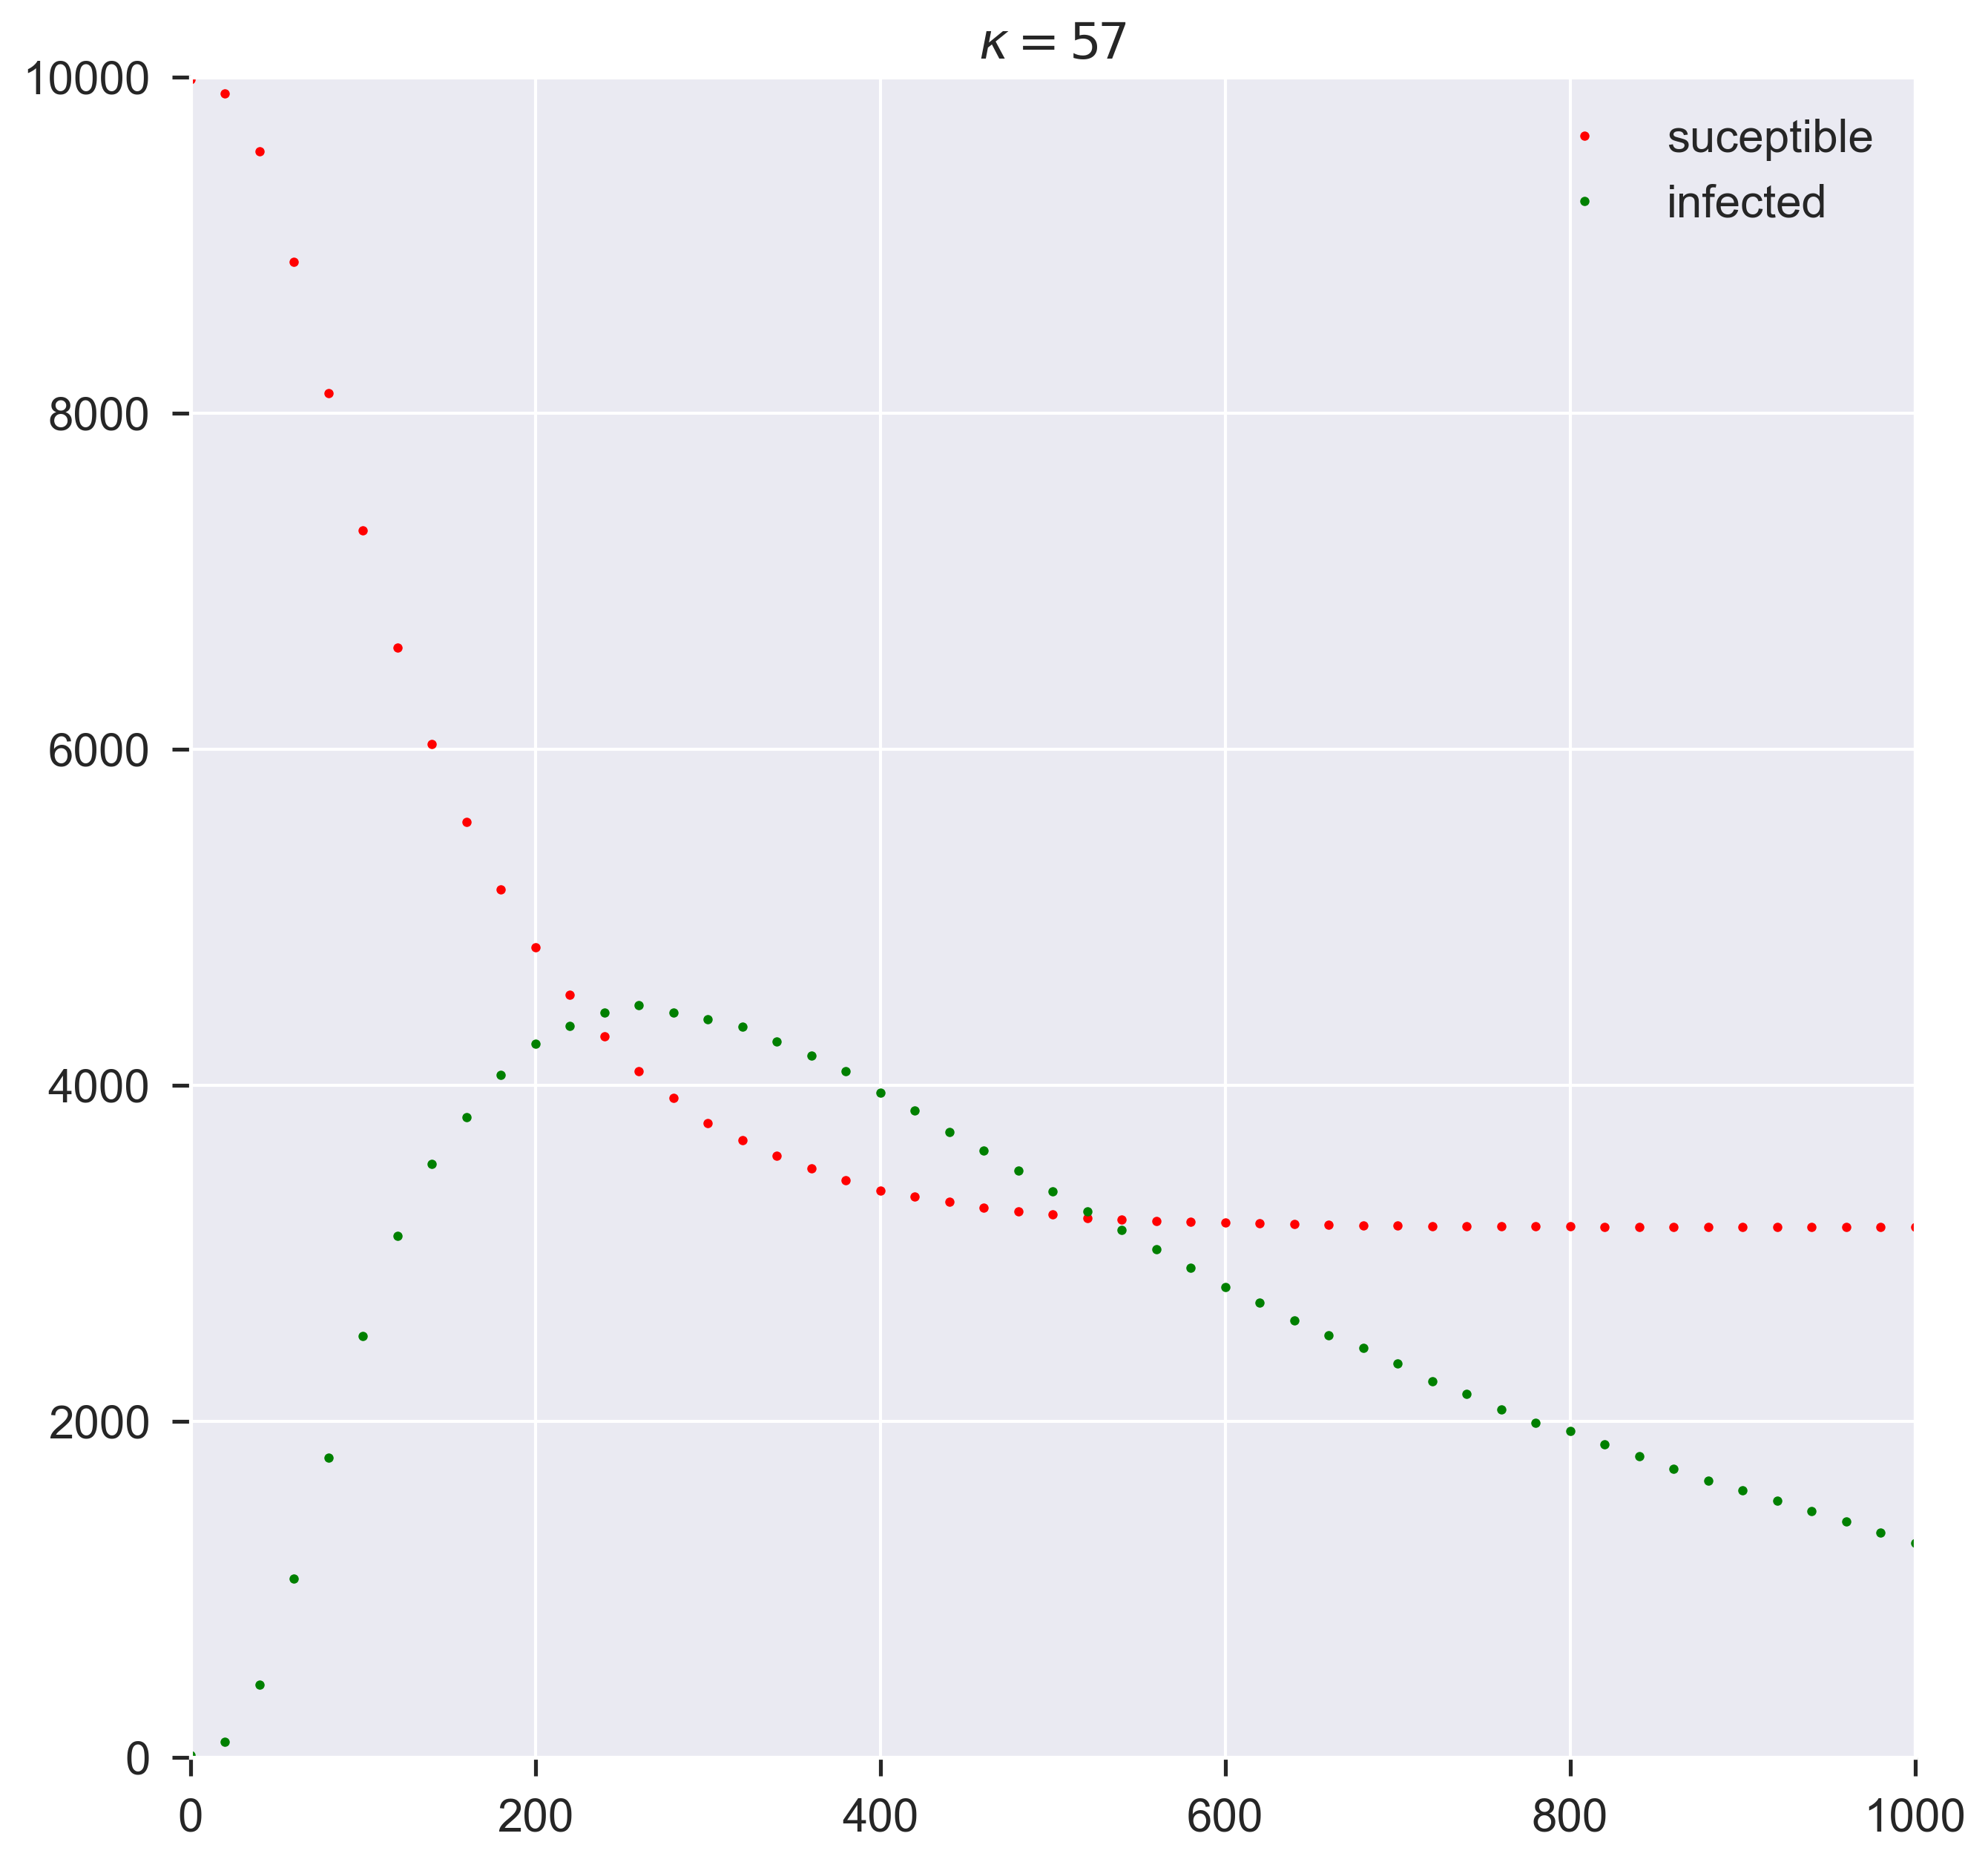

In [19]:
cutoff = 57

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                          figsize=(10, 10))

timeseries = rc['results']['epydemic.Monitor.timeseries']
ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
# ax.plot(ts, rss, 'ks', label='removed')

ax.set_title('$\\kappa = {kappa:.0f}$'.format(kappa=cutoff))
ax.set_xlim([0, T])
ax.set_ylim([0, N])
ax.legend(loc='upper right')
plt.show()

<code>rc_1</code>

In [20]:
class MonitoredVaccinatedSIR(epydemic.SIR, epydemic.Monitor):
    
    P_VACCINATED = 'pVaccinated'   #: Probability that an
                                   # individual is initially removed.
    
    def __init__(self):
        super(MonitoredVaccinatedSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredVaccinatedSIR, self).build(params)

        # change the initial compartment probabilities to vaccinate (remove) some fraction
        pInfected = params[epydemic.SIR.P_INFECTED]
        pVaccinated = params[self.P_VACCINATED]
        self.changeCompartmentInitialOccupancy(epydemic.SIR.INFECTED, pInfected)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.REMOVED, pVaccinated)
        self.changeCompartmentInitialOccupancy(epydemic.SIR.SUSCEPTIBLE, 1.0 - pInfected - pVaccinated)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

In [21]:
pVaccinated = 0.6

In [22]:
params[MonitoredVaccinatedSIR.P_VACCINATED] = pVaccinated
params[epydemic.PLCNetwork.CUTOFF] = 57

e = epydemic.StochasticDynamics(MonitoredVaccinatedSIR(), epydemic.PLCNetwork())
rc_1 = e.set(params).run()

In [23]:
# rc_1

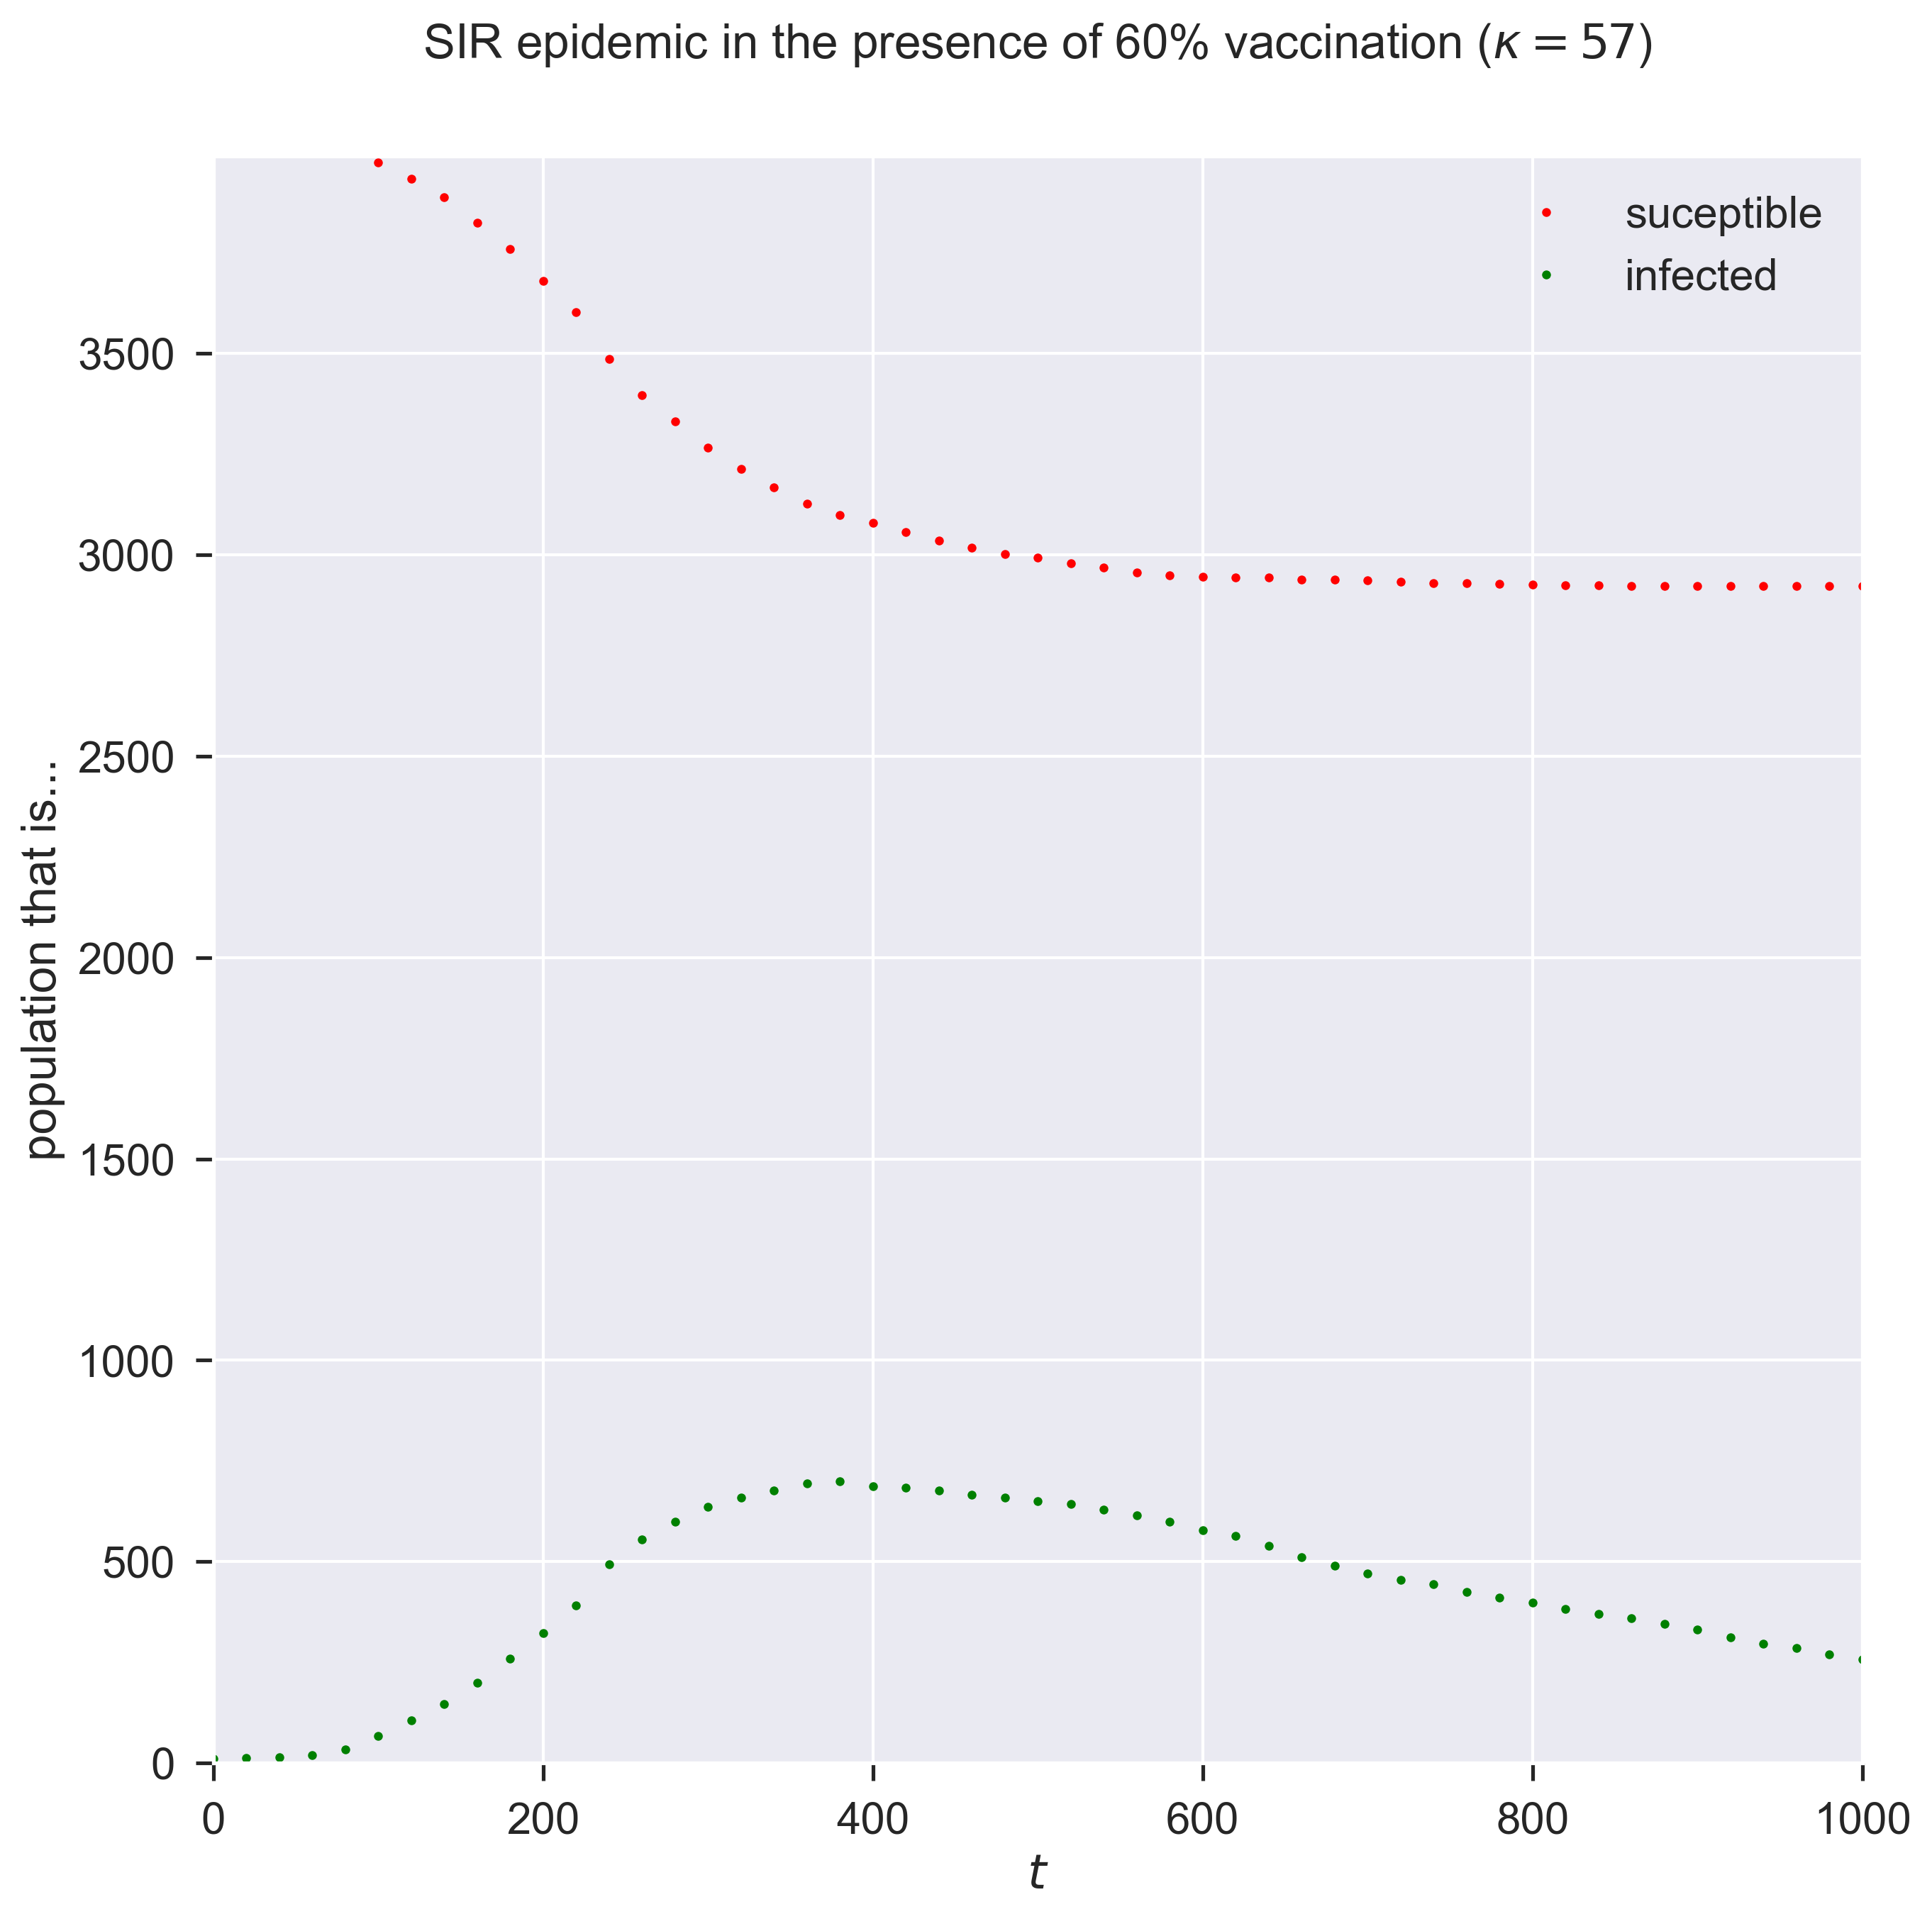

In [24]:
cutoff = 33

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                          figsize=(10, 10))

timeseries = rc_1['results']['epydemic.Monitor.timeseries']
ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N * (1.0 - pVaccinated - pInfected)])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic in the presence of {v:.0f}% vaccination ($\\kappa = {k}$)'.format(v=rc_1['parameters']['pVaccinated'] * 100, k=rc_1['parameters']['epydemic.generators.PLCNetwork.cutoff']), y=1.05)
ax.legend(loc='upper right')
plt.show()

<code>rc_2</code>

In [49]:
Nsmall = int(N * (1.0 - pVaccinated - pInfected))
params[epydemic.PLCNetwork.N] = Nsmall
params[epydemic.PLCNetwork.CUTOFF] = 57
params[MonitoredVaccinatedSIR.P_VACCINATED] = 0

e = epydemic.StochasticDynamics(MonitoredVaccinatedSIR(), epydemic.PLCNetwork())
rc_2 = e.set(params).run()

In [37]:
# rc_2

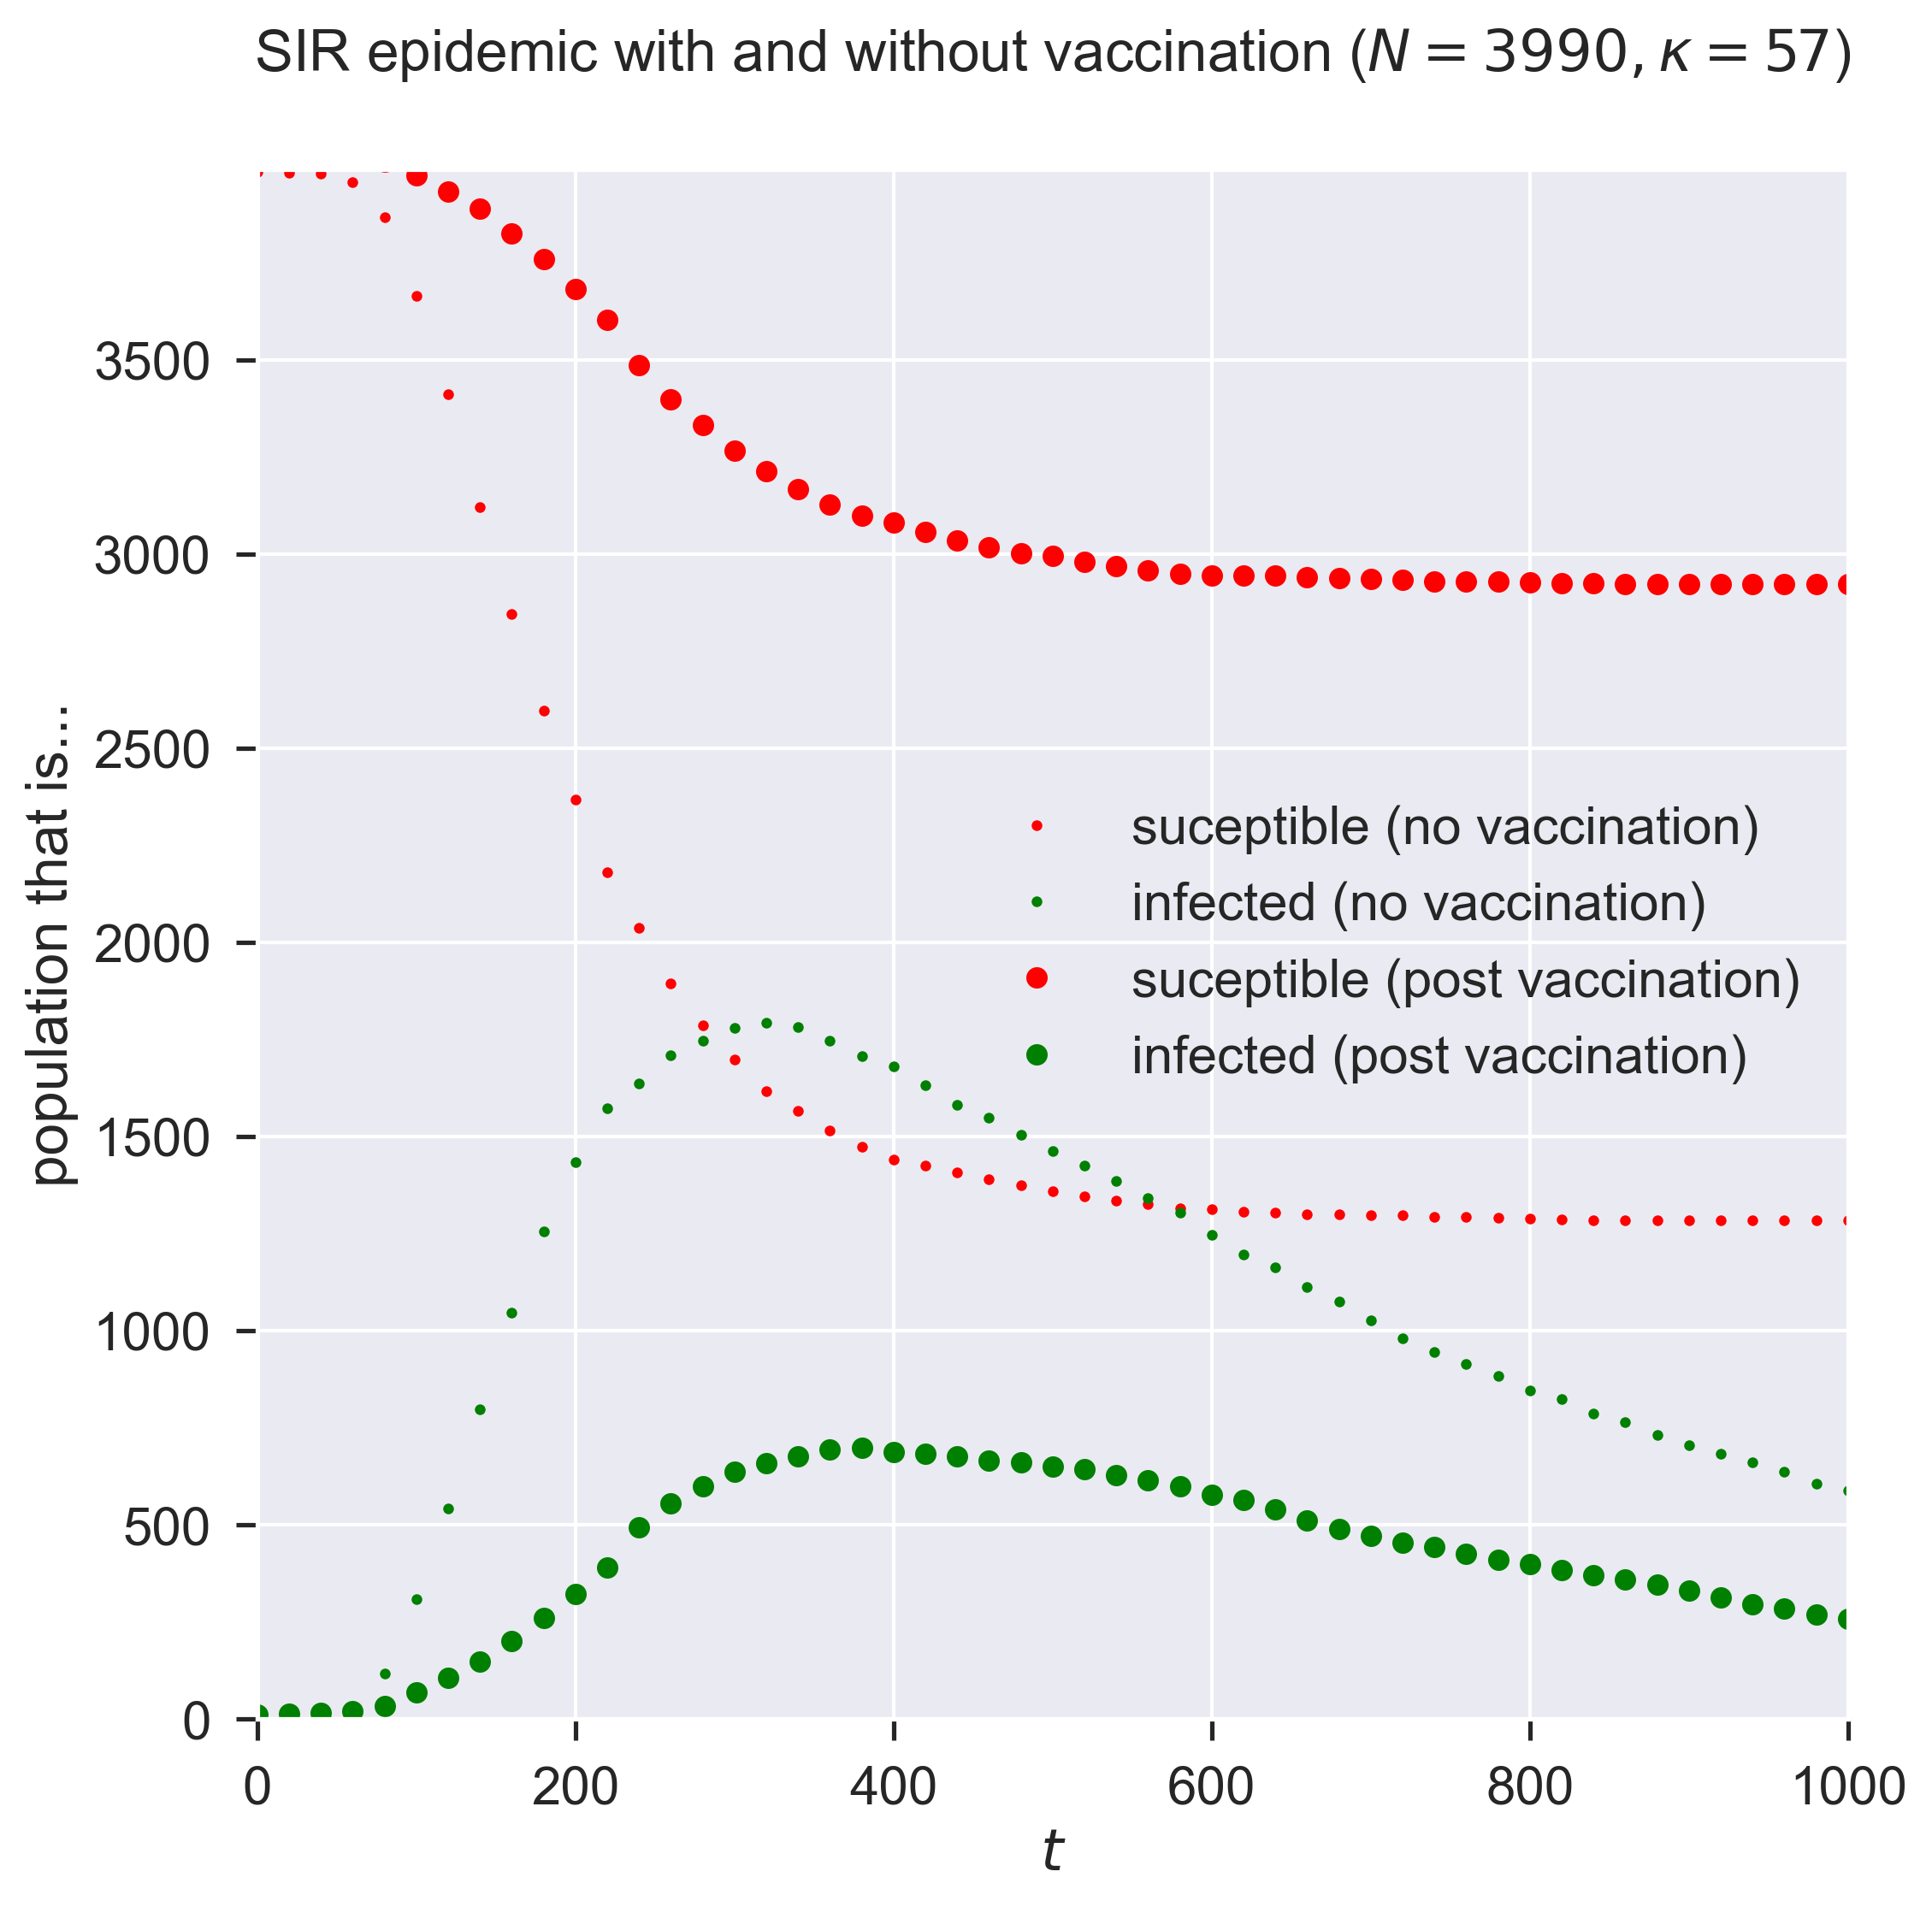

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

timeseries = rc_2['results']['epydemic.Monitor.timeseries']
ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']

ax.plot(ts, sss, 'r.', label='suceptible (no vaccination)')
ax.plot(ts, iss, 'g.', label='infected (no vaccination)')
#ax.plot(ts, rss, 'ks', label='removed')

# # plot results on same-sized network reduced in
# # size by vaccination
timeseries = rc_1['results']['epydemic.Monitor.timeseries']
ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']
ax.plot(ts, sss, 'ro', label='suceptible (post vaccination)')
ax.plot(ts, iss, 'go', label='infected (post vaccination)')
# #ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, Nsmall])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic with and without vaccination ($N = {n}, \\kappa = {k}$)'.format(n=Nsmall, k=rc_2['parameters']['epydemic.generators.PLCNetwork.cutoff']), y=1.05)
ax.legend(loc='center right')
plt.show()

Supper spreaders 

In [53]:
g = PowerLawWithCutoffNetwork()

params = dict()
params['hcn.N'] = N
params['hcn.alpha'] = alpha
params['hcn.kappa'] = 57

hcn = g._generate(params)

ks = sorted(list(dict(nx.degree(hcn)).values()))
print('Maximum degree = {kmax}'.format(kmax=max(ks)))

Maximum degree = 94


That's a high number. What about the number of contacts for an averagely-connected node?

In [54]:
print('Mean node degree = {kmean:.2f}'.format(kmean=np.mean(ks)))

Mean node degree = 2.61


Very different, and it's this feature that differentiates a human contact network from an ER network: the existence of nodes with degrees that are much higher than the average. In fact such networks have a long tail of nodes with high degrees: only a small number relative to the size of the network overall, but nonetheless able to pass infection.

In [55]:
h = 10
print('Highest {h} nodes by degree {l}'.format(h=h, l=ks[-h:]))
# print(ks)

Highest 10 nodes by degree [64, 67, 72, 84, 87, 89, 92, 92, 93, 94]


How important are these individuals in the spread of the disease? We can study that by excluding them from our model vaccination programme. Instead of vaccinating some fraction of the network, after vaccination we will make sure that some fraction of the highest-degree nodes are susceptible. Essentially we swap high-degree nodes for lower-degree nodes in our vaccination programme.

In [56]:
class MonitoredVaccinatedLowDegreeSIR(MonitoredVaccinatedSIR):

    K_HIGH_FRACTION = 'k_high_fraction'
    
    def __init__(self):
        super(MonitoredVaccinatedLowDegreeSIR, self).__init__()
        
    def setUp(self, params):
        super(MonitoredVaccinatedLowDegreeSIR, self).setUp(params)
        
        # look through the fraction of high-degree nodes and
        # make them susceptible again, replacing them with
        # another node chosen at random
        rng = np.random.default_rng()
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_HIGH_FRACTION])
        degrees = dict(nx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            if self.getCompartment(n) == self.REMOVED:
                # node is removed, make it susceptible again
                self.setCompartment(n, self.SUSCEPTIBLE)
                
                # choose another node and remove it in
                # place of the node we just forced to
                # be susceptible
                while True:
                    i = rng.integers(0, len(ns) - 1)
                    m = ns[i]
                    if self.getCompartment(m) == self.SUSCEPTIBLE:
                        # found a susceptible node, remove it
                        self.setCompartment(m, self.REMOVED)
                        break

In [57]:
kHighFraction = 0.08 

params = dict()

params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.PLCNetwork.N] = N
params[epydemic.PLCNetwork.EXPONENT] = alpha
params[epydemic.PLCNetwork.CUTOFF] = 57
params[epydemic.Monitor.DELTA] = T / 50
params[MonitoredVaccinatedLowDegreeSIR.P_VACCINATED] = 0
params[MonitoredVaccinatedLowDegreeSIR.K_HIGH_FRACTION] = kHighFraction

e = epydemic.StochasticDynamics(MonitoredVaccinatedLowDegreeSIR(), epydemic.PLCNetwork())
rc = e.set(params).run()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

timeseries = rc['results']['epydemic.Monitor.timeseries']

ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N * (1.0 - pInfected - pVaccinated) + N * kHighFraction])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic without vaccination of {khigh:.0f}% highest-degree nodes ($N = {n}, \\kappa = {k:.0f}$)'.format(khigh=kHighFraction * 100, n=N, k=rc['parameters']['epydemic.generators.PLCNetwork.cutoff']), y=1.05)
ax.legend(loc='upper right')

plt.show()

Letting a small fraction of the high-degree nodes – i.e., the most connected individuals – remain susceptible changes the epidemic again, making it larger and faster. It's not only the size of the vaccinated population that counts: it's who we vaccinate (or, in this case, don't vaccinate) that really matters. Missing even a small fraction of the highly connected will radically reduce the effectiveness of a vaccination programme.

## Targetted vaccination

So the existence of high-degree nodes offers an opportunity for the disease to infect far more individuals if those nodes are not protected by vaccination.

But this also offers opportunities for further countermeasures. If high-degree nodes are important in spreading the disease, what if – instead of vaccinating at random – we instead explicitly target those nodes that we believe are the most important in spreading the disease? That might make our programme more effective. It might also mean that we could perform a smaller, more focused, programme, where instead of vaccinating widely at random we {index}vaccinate narrowly <targetted vaccination> but in a focused, "smart" way.

We can explore this too. Rather than perform random vaccination, we instead target a specific fraction of the highest-degree nodes.

In [ ]:
class MonitoredVaccinatedHighDegreeSIR(MonitoredSIR):

    K_VACCINATED_FRACTION = 'k_vaccinated_fraction'
    
    def __init__(self):
        super(MonitoredVaccinatedHighDegreeSIR, self).__init__()
        
    def setUp(self, params):
        super(MonitoredVaccinatedHighDegreeSIR, self).setUp(params)

        # look for the fraction of highest-degree nodes
        # and vaccinate (remove) them
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_VACCINATED_FRACTION])
        degrees = dict(nx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            # remove (vaccinate) the node
            self.setCompartment(n, self.REMOVED)

In [ ]:
kVaccinatedFraction = 0.02    # top 2% highest-degree nodes

params = dict()

params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.PLCNetwork.N] = N
params[epydemic.PLCNetwork.EXPONENT] = alpha
params[epydemic.PLCNetwork.CUTOFF] = 57
params[epydemic.Monitor.DELTA] = T / 50

params[MonitoredVaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] = kVaccinatedFraction

e = epydemic.StochasticDynamics(MonitoredVaccinatedHighDegreeSIR(), epydemic.PLCNetwork())
rc = e.set(params).run()

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

timeseries = rc['results']['epydemic.Monitor.timeseries']

ts = timeseries['epydemic.Monitor.observations']
sss = timeseries['epydemic.SIR.S']
iss = timeseries['epydemic.SIR.I']
rss = timeseries['epydemic.SIR.R']

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')



ax.set_xlim([0, T])    
ax.set_xlabel('$t$')
ax.set_ylim([0, N])
ax.set_ylabel('population that is...')
ax.set_title('SIR epidemic vaccinating only the {kvac:.0f}% highest-degree nodes ($N = {n}, \\kappa = {k:.0f}$)'.format(kvac=kVaccinatedFraction * 100, n=N, k=rc['parameters']['epydemic.generators.PLCNetwork.cutoff']), y=1.05)
ax.legend(loc='upper right')

plt.show()